# Notebook 3 - Unsupervised Learning - Clustering Analysis
### Hugo C Marrochio
### Date: Nov 23 2024

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

from scipy.optimize import minimize
from sklearn.neighbors import KernelDensity

import seaborn as sns
import plotly.graph_objects as go
import random
plt.rcParams['figure.figsize'] = (8.0, 6.0) #setting figure size
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [14]:
from auxiliary_functions import *

## Summary of Clustering - Notebook 3

In this notebook, I will continue the modelling about S&P500 data from kaggle (https://www.kaggle.com/datasets/andrewmvd/sp-500-stocks). The goal of this notebook is to focus on clustering stocks by analyzing correlation matrices. We find that by "denoising" the correlation matrix eigenvalues, the clustering algorithm was more succesful in identifying stocks that their movements are related. 


### Notebook 3

#### 0 - Loading Auxiliary Functions and csv Files

    - Load the data we produced in Notebook 1.
    - Import auxiliary functions.

#### Part 1 - More on Eigenvalues and Denoising

    - We continue the analysis of the eigenvalues of the correlation matrix.
    - We identify the eigenvalues that lie in the random range. The number of eigenvalues that are outside the random range will be used as the number of PCA components for dimensional reduction.
    - We also perform denoising of the random range of eigenvalues. this consists of "flattening" the eigenvalues in the random range.

#### Part 2 - Clustering
    - We construct a simple "metric" matrix from the correlation matrix in order to do clustering algorithms.
    - We test silhouette score for 3 different clustering algorithms for both 30 and 100 stocks.
    - We briefly analyze the consistency of the clusters found.

#### Appendix - The effect of denoising on clustering?
    - We repeat clustering for top 100 stocks, but do not regularize the eigenvalues with the denoise procedure. 
    - Silhouette score does not seem to significantly deviate, but the clustering is less evenly distributed between the classes.
    - This result does suggest that denoising the correlation matrix was more effective in finding similar stock movements.






# 0. Import data set

In [3]:
df_top_100=pd.read_csv('data/sp500_stocks_top_100.csv')
df_top_60=pd.read_csv('data/sp500_stocks_top_60.csv')
df_top_30=pd.read_csv('data/sp500_stocks_top_30.csv')
df_random_100=pd.read_csv('data/sp500_stocks_random_100.csv')
df_random_60=pd.read_csv('data/sp500_stocks_random_60.csv')
df_random_30=pd.read_csv('data/sp500_stocks_random_30.csv')

In [4]:
#Transform the date column into datetime object
df_top_100['Date']=pd.to_datetime(df_top_100['Date'])
df_top_60['Date']=pd.to_datetime(df_top_60['Date'])
df_top_30['Date']=pd.to_datetime(df_top_30['Date'])
df_random_100['Date']=pd.to_datetime(df_random_100['Date'])
df_random_60['Date']=pd.to_datetime(df_random_60['Date'])
df_random_30['Date']=pd.to_datetime(df_random_30['Date'])

In [71]:
df_companies=pd.read_csv('data/sp500_companies.csv')


# Part 1 - More on Eigenvalues and Denoising

### Top 30 Stocks

First we set the condition in order to filter a specific time period. We will focus on 5 years of data.

In [5]:
condition_5y=(df_top_30['Date']>'2015-01-01')&(df_top_30['Date']<'2019-12-31')
df_top_30_5y=df_top_30[condition_5y]

Now we manipulate in order to calculate the correlation matrix, reshaping the DataFrame. 

In [8]:
grouped_top_30_5y= df_top_30_5y.groupby('Symbol')['Log_Return'].apply(list).reset_index()
values_top_30_5y = pd.DataFrame(grouped_top_30_5y['Log_Return'].tolist(), index=grouped_top_30_5y['Symbol']).T
values_top_30_5y=(values_top_30_5y-values_top_30_5y.mean())/values_top_30_5y.std()
correlation_matrix_top_30_5y=values_top_30_5y.corr()

We can visualize the correlation matrix as a heatmap

<Axes: xlabel='Symbol', ylabel='Symbol'>

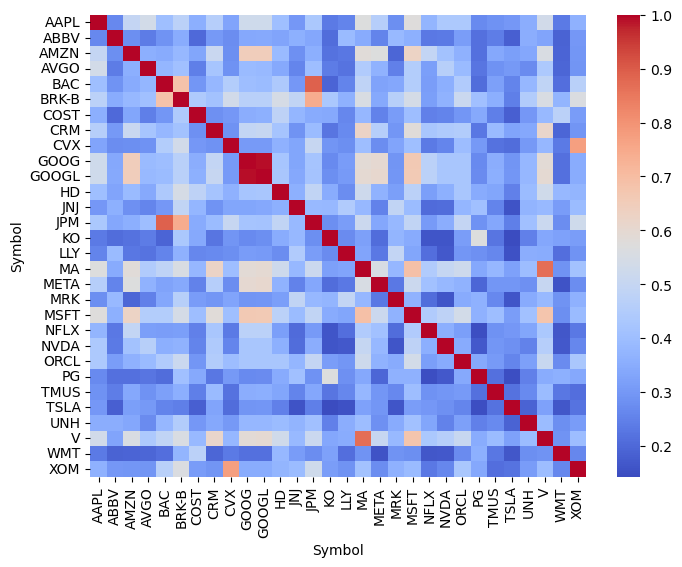

In [9]:
sns.heatmap(correlation_matrix_top_30_5y,cmap='coolwarm')

#### Eigenvalue analysis

Next, we follow with the eigenvalue analysis.

In [10]:
# Ordered descending
eig_list_top30_5y=np.linalg.eigvals(correlation_matrix_top_30_5y)

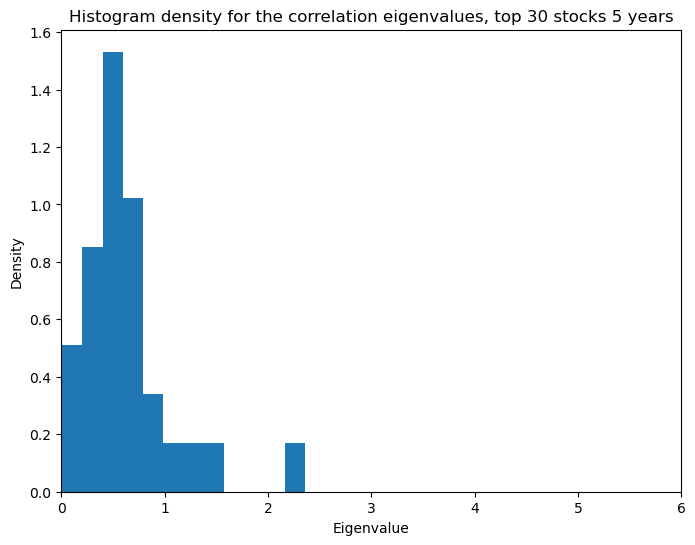

In [212]:
plt.hist(eig_list_top30_5y,bins=60,density=True)
plt.xlim([0,6])
plt.title('Histogram density for the correlation eigenvalues, top 30 stocks 5 years')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.savefig('figures/histogram_eig_top30.png')
plt.show()

We will use these two auxliary function in order to find eigenvalues and eigenvectors of of a symmetric matrix, and another one that does "denoising" for the eigenvalues in the random range.

In [20]:
print('Function: eig_dec')
print(eig_dec.__doc__)
print('Function: denoise_eig')
print(denoise_eig.__doc__)

Function: eig_dec

    
    Input:
    ------
    M: Symmetric matrix M
    
    Output:
    ------
    Lambda: Diagonal matrix with diagonal elements representing the eigenvalues in descending order
    
    eigVec: Matrix with eigenctors associate with the eigenvalues in Lambda
    
    
Function: denoise_eig

    
    Input:
    ------
    
    eigVal: Eigenvalue matrix, can be for instance the output of eig_dec()

    eigVec: Eigenvector matrix, can be for instance the output of eig_dec()

    n_random: number of eigenvalues OUTSIDE the range of randomness.

    
    
    Output:
    ------

    C_norm: Symmetric matrix where the eigenvalues in the random range were regularized.
    
    


We run first the optimization that finds the parameters of the MP pdf that fits the data

In [23]:
eMax_top30, sigma_opt_top30,q_opt_top30=findMaxEval(np.array(eig_list_top30_5y),bWidth=0.15,flag = True)

SSE: 1008.3599832490107
SSE: 1008.3599058771682
SSE: 1008.3599837027675
SSE: 59.13898932905758
SSE: 59.138988870021464
SSE: 59.13898928223191
SSE: 56.590626639461334
SSE: 56.59063048576884
SSE: 56.59062669687168
SSE: 49.89381572794486
SSE: 49.89381613781991
SSE: 49.89381571672142
SSE: 49.45396881428769
SSE: 49.4539697772656
SSE: 49.45396881605524
SSE: 49.44451319674617
SSE: 49.44451407267978
SSE: 49.444513196558276
SSE: 49.444402452669266
SSE: 49.444403336781164
SSE: 49.44440245266618
SSE: 49.444402422340616
SSE: 49.44440330658931
SSE: 49.44440242234053
Optimization result:   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 49.444402422340616
        x: [ 1.000e+00  7.591e+00]
      nit: 6
      jac: [-8.842e+01 -8.527e-06]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


Since the size of the correlation matrix for 30 stocks is not large (30x30), it is good to be conservative and maintain more eigenvalues then what `eMax_top30` suggests. 

In [31]:
eig_list_top30_5y[eig_list_top30_5y>0.5*eMax_top30].shape[0]

6

We can now construct the denoised correlation matrix using the auxiliary functions `eig_dec` and `denoise_eig`

In [32]:
Lambda_top30, eigVec_top30=eig_dec(correlation_matrix_top_30_5y)
correlation_matrix_top_30_5y_denoised=denoise_eig(Lambda_top30,eigVec_top30,6)

Shape of eigVal is (30, 30)
Shape of eigVal_den is (30, 30)
Shape of eigVec is (30, 30)
Shape of C is (30, 30)
Shape of std is (30,)
Shape of outer is (30, 30)


Since we did not operate on the eigenvectors, the transformation back mantains the relative order between stocks. In order to be more specific, we can create a pandas DataFrame with the same indexes.

In [44]:
list_stocks_top30=correlation_matrix_top_30_5y.columns.tolist()

In [46]:
correlation_matrix_top_30_5y_denoised=pd.DataFrame(correlation_matrix_top_30_5y_denoised,columns=list_stocks_top30,index=list_stocks_top30)

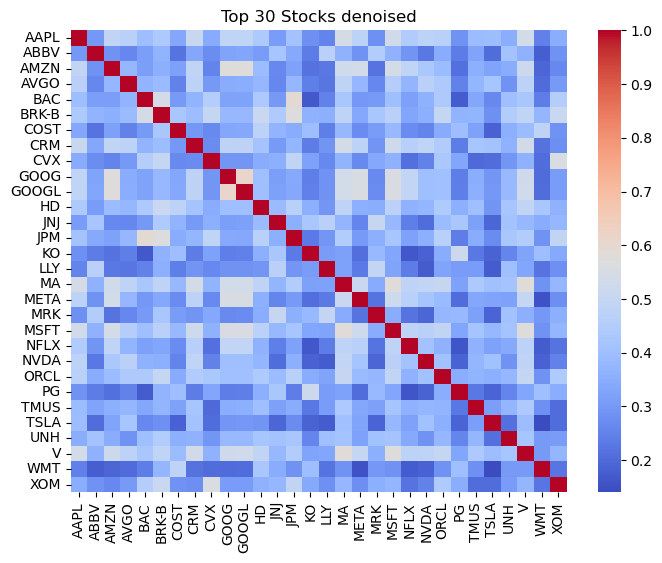

In [215]:
sns.heatmap(correlation_matrix_top_30_5y_denoised,cmap='coolwarm')
plt.title('Top 30 Stocks denoised')
plt.savefig('figures/Heatmap_top30_denoised.png')
plt.show()

We notice that the correlation matrix seems is more uniform after denoising the eigenvalues in the random range. 

We can also plot the log of the eigenvalues to compare the effect of denoising, we compare the log of the eigenvalues in order for better visualization

In [48]:
log_eig_list_top_30_5y=np.log(eig_list_top30_5y)
log_eig_list_top_30_5y.sort()
log_eig_list_top_30_5y=log_eig_list_top_30_5y[::-1]

#now with the denoisd as well
eig_list_top_30_5y_denoised=np.linalg.eigvals(correlation_matrix_top_30_5y_denoised)
log_eig_list_top_30_5y_denoised=np.log(eig_list_top_30_5y_denoised)
log_eig_list_top_30_5y_denoised.sort()
log_eig_list_top_30_5y_denoised=log_eig_list_top_30_5y_denoised[::-1]

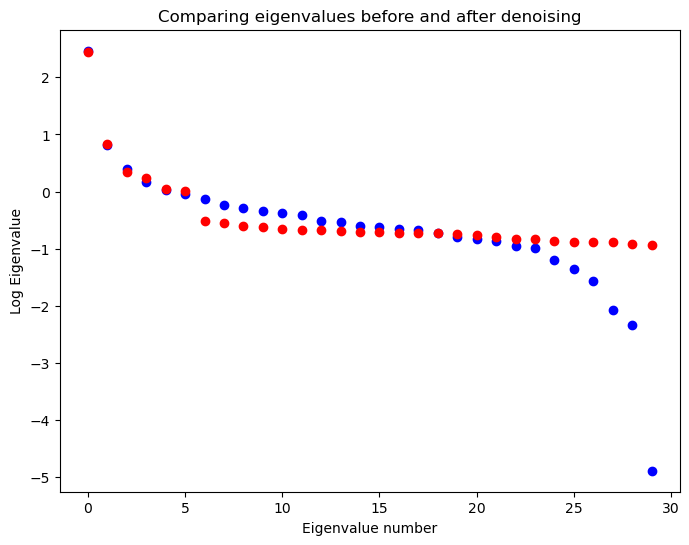

In [216]:
plt.scatter(np.arange(0, 30),log_eig_list_top_30_5y,color='blue')
plt.scatter(np.arange(0, 30),log_eig_list_top_30_5y_denoised,color='red')
#plt.xlim([0,6])
plt.title('Comparing eigenvalues before and after denoising')
plt.xlabel('Eigenvalue number')
plt.ylabel('Log Eigenvalue')
plt.savefig('figures/Eig_denoising_top30.png')
plt.show()

We see the effect of denoising on the eigenvalues: most eigenvalues have a flatter spectrum after denoising, so it tames the singular value due to the small eigenvalues of the correlation matrix.

### Eigenvalue analysis for top 100

Filter for a period of 5 years

In [85]:
condition_5y=(df_top_100['Date']>'2015-01-01')&(df_top_100['Date']<'2019-12-31')
df_top_100_5y=df_top_100[condition_5y]

Now we manipulate in order to calculate the correlation matrix, reshaping the DataFrame. 

In [87]:
grouped_top_100_5y= df_top_100_5y.groupby('Symbol')['Log_Return'].apply(list).reset_index()
values_top_100_5y = pd.DataFrame(grouped_top_100_5y['Log_Return'].tolist(), index=grouped_top_100_5y['Symbol']).T
values_top_100_5y=(values_top_100_5y-values_top_100_5y.mean())/values_top_100_5y.std()
correlation_matrix_top_100_5y=values_top_100_5y.corr()

We can visualize the correlation matrix as a heatmap

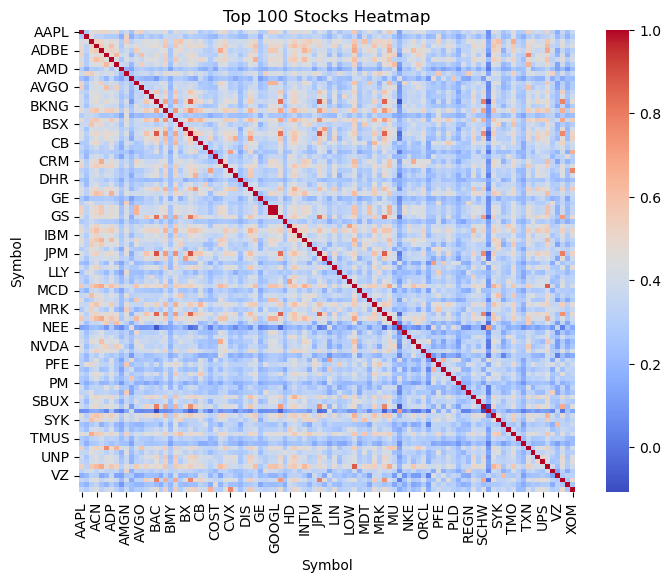

In [217]:
sns.heatmap(correlation_matrix_top_100_5y,cmap='coolwarm')
plt.title('Top 100 Stocks Heatmap')
plt.savefig('figures/Heatmap_top100.png')
plt.show()

#### Eigenvalue analysis

Next, we follow with the eigenvalue analysis.

In [89]:
# Ordered descending
eig_list_top100_5y=np.linalg.eigvals(correlation_matrix_top_100_5y)

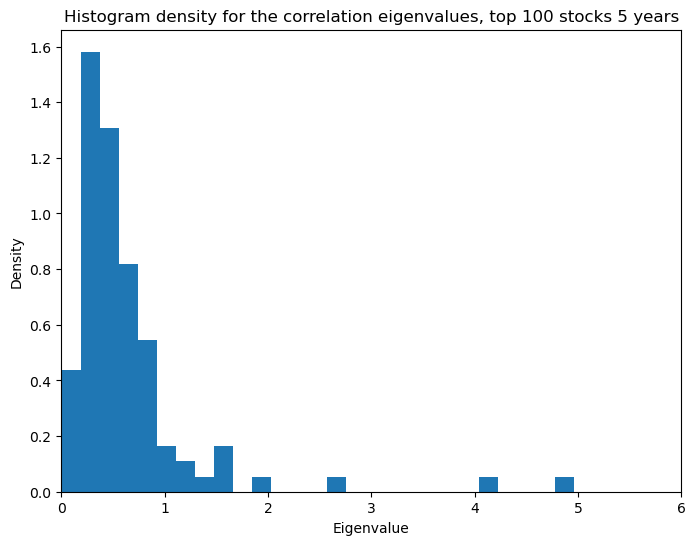

In [219]:
plt.hist(eig_list_top100_5y,bins=200,density=True)
plt.xlim([0,6])
plt.title('Histogram density for the correlation eigenvalues, top 100 stocks 5 years')
plt.xlabel('Eigenvalue')
plt.ylabel('Density')
plt.savefig('figures/histogram_eig_top100.png')
plt.show()

We run first the optimization that finds the parameters of the MP pdf that fits the data

In [96]:
eMax_top100, sigma_opt_top100,q_opt_top100=findMaxEval(np.array(eig_list_top100_5y),bWidth=0.15,flag = True)

SSE: 642.3564157226933
SSE: 642.3563566115924
SSE: 642.3564160666626
SSE: 54.50506266490422
SSE: 54.50506081517108
SSE: 54.50506261732996
SSE: 35.946637969196566
SSE: 35.9466396308125
SSE: 35.94663799082151
SSE: 35.37365884448566
SSE: 35.37365832039566
SSE: 35.373658829002494
SSE: 34.703723319463435
SSE: 34.703723954872245
SSE: 34.703723324827635
SSE: 34.619428877953744
SSE: 34.61942918585126
SSE: 34.619428877744724
SSE: 34.61929868960285
SSE: 34.61929900942591
SSE: 34.61929868960047
SSE: 34.61929867344507
SSE: 34.619298993405735
SSE: 34.6192986734451
Optimization result:   message: CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
  success: True
   status: 0
      fun: 34.61929867344507
        x: [ 1.000e+00  1.141e+01]
      nit: 7
      jac: [-3.200e+01  2.842e-06]
     nfev: 24
     njev: 8
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>


Since we have more data, we can be a bit more relaxed about the cutoff to the random range.  

In [100]:
eig_list_top100_5y[eig_list_top100_5y>0.75*eMax_top100].shape[0]

9

We can now construct the denoised correlation matrix using the auxiliary functions `eig_dec` and `denoise_eig`

In [101]:
Lambda_top100, eigVec_top100=eig_dec(correlation_matrix_top_100_5y)
correlation_matrix_top_100_5y_denoised=denoise_eig(Lambda_top100,eigVec_top100,9)

Shape of eigVal is (100, 100)
Shape of eigVal_den is (100, 100)
Shape of eigVec is (100, 100)
Shape of C is (100, 100)
Shape of std is (100,)
Shape of outer is (100, 100)


Since we did not operate on the eigenvectors, the transformation back mantains the relative order between stocks. In order to be more specific, we can create a pandas DataFrame with the same indexes.

In [104]:
list_stocks_top100=correlation_matrix_top_100_5y.columns.tolist()

In [105]:
correlation_matrix_top_100_5y_denoised=pd.DataFrame(correlation_matrix_top_100_5y_denoised,columns=list_stocks_top100,index=list_stocks_top100)

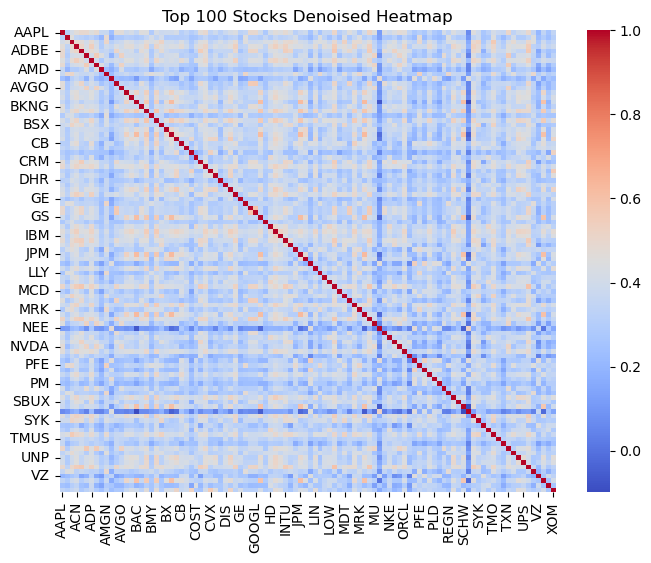

In [218]:
sns.heatmap(correlation_matrix_top_100_5y_denoised,cmap='coolwarm')
plt.title('Top 100 Stocks Denoised Heatmap')
plt.savefig('figures/Heatmap_top100_denoised.png')
plt.show()

Once again, we notice that the correlation matrix seems is more uniform after denoising the eigenvalues in the random range. 

We can also plot the log of the eigenvalues to compare the effect of denoising, we compare the log of the eigenvalues in order for better visualization

In [107]:
log_eig_list_top_100_5y=np.log(eig_list_top100_5y)
log_eig_list_top_100_5y.sort()
log_eig_list_top_100_5y=log_eig_list_top_100_5y[::-1]

#now with the denoisd as well
eig_list_top_100_5y_denoised=np.linalg.eigvals(correlation_matrix_top_100_5y_denoised)
log_eig_list_top_100_5y_denoised=np.log(eig_list_top_100_5y_denoised)
log_eig_list_top_100_5y_denoised.sort()
log_eig_list_top_100_5y_denoised=log_eig_list_top_100_5y_denoised[::-1]

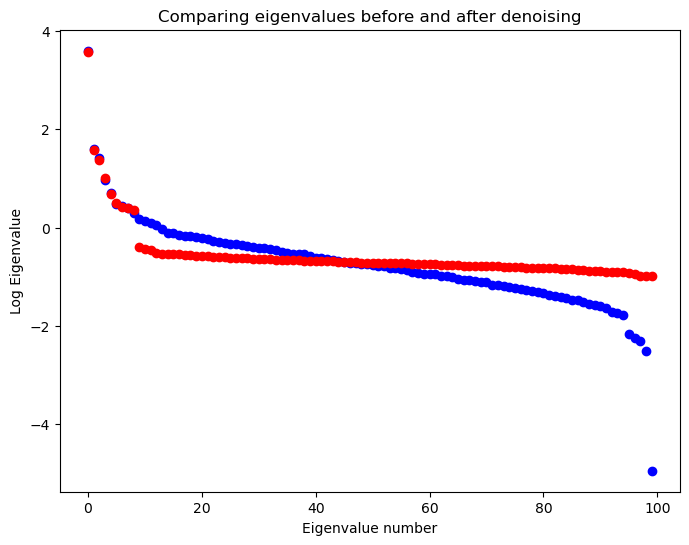

In [220]:
plt.scatter(np.arange(0, 100),log_eig_list_top_100_5y,color='blue')
plt.scatter(np.arange(0, 100),log_eig_list_top_100_5y_denoised,color='red')
#plt.xlim([0,6])
plt.title('Comparing eigenvalues before and after denoising')
plt.xlabel('Eigenvalue number')
plt.ylabel('Log Eigenvalue')
plt.savefig('figures/Eig_denoising_top100.png')
plt.show()

# Part 2 - Cluster

### Top 30

We will follow the procedure from the Lopez-Prado book, where we construct an equivalent mathematical variable from the correlation matrix, but one that obeys axioms for metric. It is a simple operation as $X=\sqrt{\frac{1-\rho}{2}}$, where $\rho$ is the correlation matrix, and we will use the one after regularizing the eigenvalues in the random range.

In [50]:
X_den_top_30=np.sqrt((1-correlation_matrix_top_30_5y_denoised)/2)

Next, we should follow the analysis with PCA. In fact, our eigenvalue analysis is nothing more than the background behind PCA. Recall that PCA finds the directions with the most variance in the data, which is exactly given by the eigenvalues of the correlation matrix! 

In a sense, one of the most useful insights so far from RMT is that it estimates how many PCA components should really be included in the analysis.

Notice that for now I am not excluding the largest eigenvalue (the market component), since it simply detects the market movement across all the stocks, it should not influence much for the clustering. 

In [53]:
pca_scaled = PCA(n_components= 6)

X_den_top_30_PCA_array = pca_scaled.fit_transform(X_den_top_30)

In [54]:
X_den_top_30_PCA = pd.DataFrame(X_den_top_30_PCA_array, columns = ['PC0', 'PC1', 'PC2','PC3','PC4','PC5'], index = list_stocks_top30)

In [57]:
# let us do head in order to check the correlation after PCA trnasformed
X_den_top_30_PCA.head()

,PC0,PC1,PC2,PC3,PC4,PC5
AAPL,-0.242770,-0.038615,0.074443,0.000599,0.030324,-0.104100
ABBV,0.176932,0.082099,-0.382035,-0.116983,-0.027356,0.051071
AMZN,-0.332031,0.127785,-0.013198,0.102552,0.074191,0.129483
AVGO,-0.148210,-0.028139,0.120704,-0.278452,0.007481,-0.143902
BAC,0.039937,-0.371174,-0.002592,-0.082129,-0.134503,0.160719


Now, we are ready to test clustering algorithms. We will run 3 different models, K-means, Gaussian Mixture and Agglomerative Clustering. We will test which cluster number ks has the best silhouette score. 

In [62]:
# Test number of cluster
ks = np.arange(2, 25)
silScoresKMeans = []
silScoresGauss = []
silScoresAgglom = []

In [63]:
for k in ks:
    print(f'Currently working on k = {k}')

    #instantiate these three models
    kmeans = KMeans(n_clusters = k)
    gauss = GaussianMixture(n_components = k)
    agglom = AgglomerativeClustering(n_clusters = k, linkage = 'ward')

    #fit the three models to the data
    kmeans.fit(X_den_top_30_PCA)
    gauss.fit(X_den_top_30_PCA)
    agglom.fit(X_den_top_30_PCA)

    #populate the lists with the silhouette scores!
    silScoresKMeans.append(silhouette_score(X_den_top_30_PCA, kmeans.labels_))
    silScoresAgglom.append(silhouette_score(X_den_top_30_PCA, agglom.labels_))
    silScoresGauss.append(silhouette_score(X_den_top_30_PCA, gauss.predict(X_den_top_30_PCA)))

Currently working on k = 2
Currently working on k = 3
Currently working on k = 4
Currently working on k = 5
Currently working on k = 6
Currently working on k = 7
Currently working on k = 8
Currently working on k = 9
Currently working on k = 10
Currently working on k = 11
Currently working on k = 12
Currently working on k = 13
Currently working on k = 14
Currently working on k = 15
Currently working on k = 16
Currently working on k = 17
Currently working on k = 18
Currently working on k = 19
Currently working on k = 20
Currently working on k = 21
Currently working on k = 22
Currently working on k = 23
Currently working on k = 24


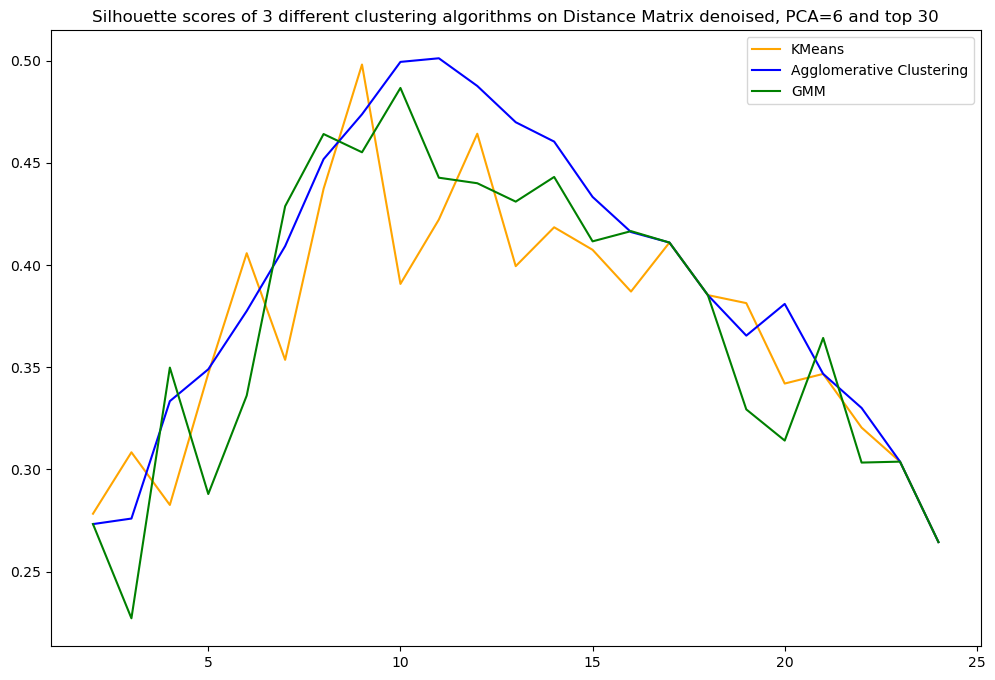

In [221]:
plt.figure(figsize=(12,8))
plt.plot(ks, silScoresKMeans, label='KMeans', color='orange')
plt.plot(ks, silScoresAgglom, label='Agglomerative Clustering', color='blue')
plt.plot(ks, silScoresGauss, label='GMM', color='green')
plt.legend() 
plt.title('Silhouette scores of 3 different clustering algorithms on Distance Matrix denoised, PCA=6 and top 30')
plt.savefig('figures/silscore_top30.png')
plt.show()

We see all the algorithms did reasonably similar, but the best one seems to be Agglomerative Clustering at `k=10`. Let us re-run the model for `k=10`.

In [67]:
agglom_top30 = AgglomerativeClustering(n_clusters = 10, linkage = 'ward')
agglom_top30.fit(X_den_top_30_PCA)
agglom_top30_Labels = agglom_top30.fit_predict(X_den_top_30_PCA)

Now let us create a temporary DataFrame including the labels the algorithm produced

In [68]:
data_explore_top30={'Stocks':list_stocks_top30,'Category':agglom_top30_Labels}

In [69]:
data_explore_top30_df=pd.DataFrame(data_explore_top30)

In [70]:
data_explore_top30_df.groupby('Category').count()

,Stocks
Category,
0,4
1,2
2,5
3,3
4,3
5,2
6,2
7,2
8,5


We see that a few clusters contain more stocks. Let us investigate a few of these clusters.

In [72]:
df_companies[df_companies['Symbol'].isin(data_explore_top30_df[data_explore_top30_df['Category']==0]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
9,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,906.13,815903014912,1.550190e+10,0.360,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.014970
21,NYQ,JNJ,Johnson & Johnson,Johnson & Johnson,Healthcare,Drug Manufacturers - General,162.83,391970881536,3.011000e+10,0.052,New Brunswick,NJ,United States,131900.0,"Johnson & Johnson, together with its subsidiar...",0.007192
23,NYQ,ABBV,AbbVie Inc.,AbbVie Inc.,Healthcare,Drug Manufacturers - General,186.54,329493053440,2.612100e+10,0.043,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.006046
28,NYQ,MRK,"Merck & Company, Inc.","Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,106.34,269551697920,2.363200e+10,0.072,Rahway,NJ,United States,70000.0,"Merck & Co., Inc. operates as a healthcare com...",0.004946


In [77]:
df_companies[df_companies['Symbol'].isin(data_explore_top30_df[data_explore_top30_df['Category']==5]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
14,NYQ,XOM,Exxon Mobil Corporation,Exxon Mobil Corporation,Energy,Oil & Gas Integrated,120.08,533495021568,7.090300e+10,0.120,Spring,TX,United States,62000.0,Exxon Mobil Corporation engages in the explora...,0.009789
27,NYQ,CVX,Chevron Corporation,Chevron Corporation,Energy,Oil & Gas Integrated,150.88,273809473536,4.100400e+10,0.048,San Ramon,CA,United States,45600.0,"Chevron Corporation, through its subsidiaries,...",0.005024


We see interestingly clusters that include stocks that make sense to be correlated: Exxon and Chevron in one cluster, Drug Manufacturer stocks in a different one.

In [79]:
df_companies[df_companies['Symbol'].isin(data_explore_top30_df[data_explore_top30_df['Category']==2]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,236.48,3595465654272,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.065970
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,418.78,3112808480768,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.057115
13,NYQ,V,Visa Inc.,Visa Inc.,Financial Services,Credit Services,286.85,558175682560,2.438400e+10,0.096,San Francisco,CA,United States,NaN,Visa Inc. operates as a payment technology com...,0.010242
17,NYQ,MA,Mastercard Incorporated,Mastercard Incorporated,Financial Services,Credit Services,515.01,475784282112,1.624400e+10,0.110,Purchase,NY,United States,33400.0,"Mastercard Incorporated, a technology company,...",0.008730
26,NYQ,CRM,"Salesforce, Inc.","Salesforce, Inc.",Technology,Software - Application,291.29,278473244672,9.345000e+09,0.084,San Francisco,CA,United States,72682.0,"Salesforce, Inc. provides Customer Relationshi...",0.005109


This one is also interesting, it clustered together big technology companies with Visa and Mastercard, which at first seems a bit surprising. With some research, it seems to be understood that due to increase of credit card expenditure online, the stocks follow some movements with big tech companies. Notice that this is __NOT__ information the model knows, everything we had was just the correlation between `Log-Returns`. 

Finally, let us include the clustering data to our dataframe.

In [86]:
data_explore_top30_df.to_csv('data/top30_cluster.csv')

#### Showing the original correlation matrix clustered top 30

Let us order the list of stocks according to the clustered indexes

In [148]:
df_top30_cluster=data_explore_top30_df.sort_values('Category')

In [149]:
list_clustered_top30=df_top30_cluster['Stocks'].to_list()

Now let us simply calculate the correlation matrix, but using the clustering order

In [150]:
correlation_matrix_top_30_5y_c=values_top_30_5y[list_clustered_top30].corr()

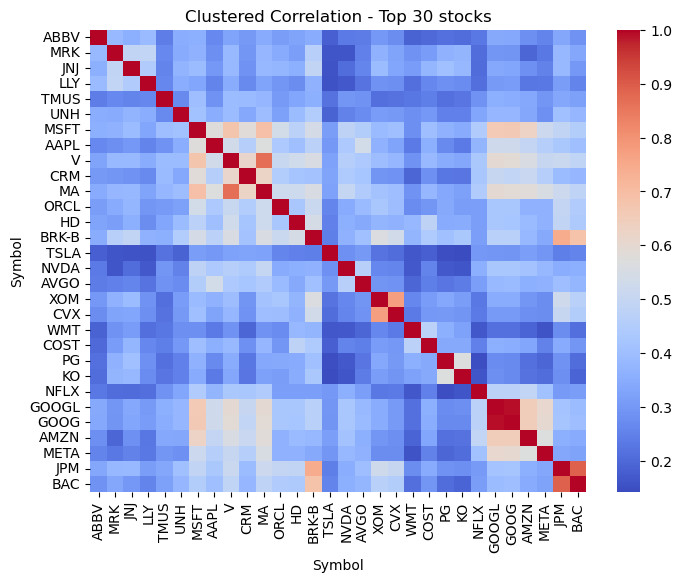

In [222]:
sns.heatmap(correlation_matrix_top_30_5y_c,cmap='coolwarm')
plt.title('Clustered Correlation - Top 30 stocks')
plt.savefig('figures/Heatmap_top30_clustered.png')
plt.show()

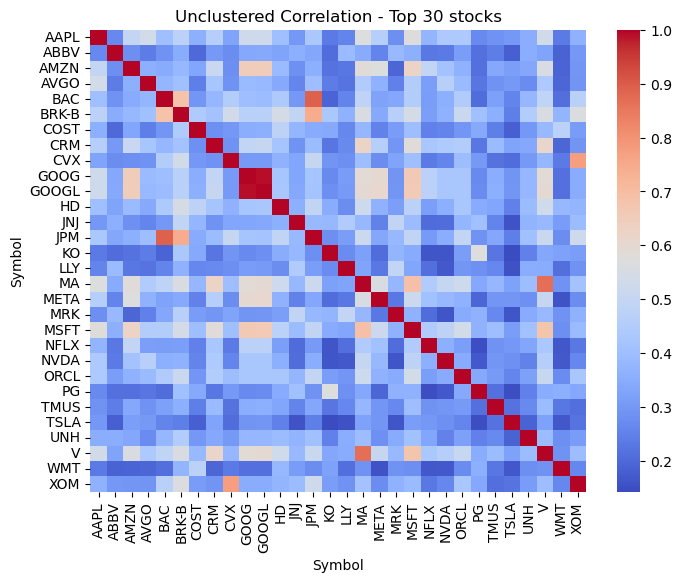

In [163]:
sns.heatmap(correlation_matrix_top_30_5y,cmap='coolwarm')
plt.title('Unclustered Correlation - Top 30 stocks')
plt.show()

We can see the correlation matrix with the clustered indexes showing some local structures with rectangular blocks!

### Clustering top 100

Same procedure, we construct the metric matrix X from the correlation matrix $\rho$ $X=\sqrt{\frac{1-\rho}{2}$.

In [110]:
X_den_top_100=np.sqrt((1-correlation_matrix_top_100_5y_denoised)/2)

We now use 9 PCA components, as our fit for the random range suggested.

In [111]:
pca_scaled = PCA(n_components= 9)

X_den_top_100_PCA_array = pca_scaled.fit_transform(X_den_top_100)

In [112]:
X_den_top_100_PCA = pd.DataFrame(X_den_top_100_PCA_array, columns = ['PC0', 'PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8'], index = list_stocks_top100)

In [113]:
# let us do head in order to check the correlation after PCA transformed
X_den_top_100_PCA.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
AAPL,0.212300,-0.220552,-0.001790,0.123945,-0.067820,0.112798,-0.024710,0.099776,-0.014393
ABBV,-0.189619,-0.097155,0.034807,-0.390044,-0.036374,0.055631,-0.046869,0.007062,0.029236
ABT,0.145232,-0.059963,-0.271699,-0.227204,-0.101509,-0.048258,0.053224,-0.059361,-0.043227
ACN,0.249312,0.020022,-0.308351,0.100581,-0.045945,-0.024002,-0.019517,-0.009064,-0.002673
ADBE,0.185259,-0.354082,-0.181921,0.098766,0.024053,-0.038832,-0.048148,-0.039612,0.013264


Test the 3 clustering for silhouette score

In [115]:
# Test number of cluster
ks2 = np.arange(2, 50)
silScoresKMeans2 = []
silScoresGauss2 = []
silScoresAgglom2 = []

In [116]:
for k in ks2:
    print(f'Currently working on k = {k}')

    #instantiate these three models
    kmeans2 = KMeans(n_clusters = k)
    gauss2 = GaussianMixture(n_components = k)
    agglom2 = AgglomerativeClustering(n_clusters = k, linkage = 'ward')

    #fit the three models to the data
    kmeans2.fit(X_den_top_100_PCA)
    gauss2.fit(X_den_top_100_PCA)
    agglom2.fit(X_den_top_100_PCA)

    #populate the lists with the silhouette scores!
    silScoresKMeans2.append(silhouette_score(X_den_top_100_PCA, kmeans2.labels_))
    silScoresAgglom2.append(silhouette_score(X_den_top_100_PCA, agglom2.labels_))
    silScoresGauss2.append(silhouette_score(X_den_top_100_PCA, gauss2.predict(X_den_top_100_PCA)))

Currently working on k = 2
Currently working on k = 3
Currently working on k = 4
Currently working on k = 5
Currently working on k = 6
Currently working on k = 7
Currently working on k = 8
Currently working on k = 9
Currently working on k = 10
Currently working on k = 11
Currently working on k = 12
Currently working on k = 13
Currently working on k = 14
Currently working on k = 15
Currently working on k = 16
Currently working on k = 17
Currently working on k = 18
Currently working on k = 19
Currently working on k = 20
Currently working on k = 21
Currently working on k = 22
Currently working on k = 23
Currently working on k = 24
Currently working on k = 25
Currently working on k = 26
Currently working on k = 27
Currently working on k = 28
Currently working on k = 29
Currently working on k = 30
Currently working on k = 31
Currently working on k = 32
Currently working on k = 33
Currently working on k = 34
Currently working on k = 35
Currently working on k = 36
Currently working on k = 37


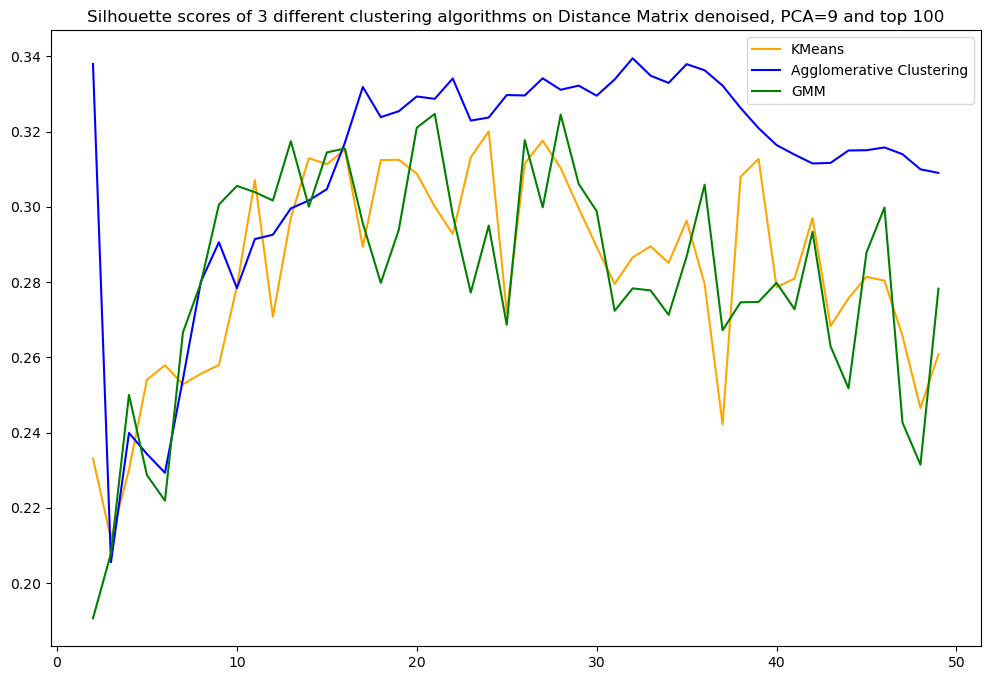

In [224]:
plt.figure(figsize=(12,8))
plt.plot(ks2, silScoresKMeans2, label='KMeans', color='orange')
plt.plot(ks2, silScoresAgglom2, label='Agglomerative Clustering', color='blue')
plt.plot(ks2, silScoresGauss2, label='GMM', color='green')
plt.legend() 
plt.title('Silhouette scores of 3 different clustering algorithms on Distance Matrix denoised, PCA=9 and top 100')
plt.savefig('figures/silscore_top100.png')
plt.show()

We see overall that Agglomerative Clustering did better. We will not necessarily use the maximum value, as having slightly smaller number of clusters might be more useful for interpretability. A good equilibrium between Silhouette score and smaller number of clusters could be `k=16`.

In [123]:
agglom_top100 = AgglomerativeClustering(n_clusters = 16, linkage = 'ward')
agglom_top100.fit(X_den_top_100_PCA)
agglom_top100_Labels = agglom_top100.fit_predict(X_den_top_100_PCA)

Now let us create a temporary DataFrame including the labels the algorithm produced

In [124]:
data_explore_top100={'Stocks':list_stocks_top100,'Category':agglom_top100_Labels}

In [125]:
data_explore_top100_df=pd.DataFrame(data_explore_top100)

In [126]:
data_explore_top100_df.groupby('Category').count()

,Stocks
Category,
0,8
1,10
2,8
3,6
4,10
5,4
6,8
7,5
8,2


A few clusters contain more stocks but overall a good distribution! Let us explicitly show some of the clusters.

In [128]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==1]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
9,NYQ,LLY,Eli Lilly and Company,Eli Lilly and Company,Healthcare,Drug Manufacturers - General,906.13,815903014912,1.550190e+10,0.360,Indianapolis,IN,United States,43000.0,"Eli Lilly and Company discovers, develops, and...",0.014970
21,NYQ,JNJ,Johnson & Johnson,Johnson & Johnson,Healthcare,Drug Manufacturers - General,162.83,391970881536,3.011000e+10,0.052,New Brunswick,NJ,United States,131900.0,"Johnson & Johnson, together with its subsidiar...",0.007192
23,NYQ,ABBV,AbbVie Inc.,AbbVie Inc.,Healthcare,Drug Manufacturers - General,186.54,329493053440,2.612100e+10,0.043,North Chicago,IL,United States,50000.0,"AbbVie Inc. discovers, develops, manufactures,...",0.006046
28,NYQ,MRK,"Merck & Company, Inc.","Merck & Co., Inc.",Healthcare,Drug Manufacturers - General,106.34,269551697920,2.363200e+10,0.072,Rahway,NJ,United States,70000.0,"Merck & Co., Inc. operates as a healthcare com...",0.004946
56,NMS,AMGN,Amgen Inc.,Amgen Inc.,Healthcare,Drug Manufacturers - General,316.74,170193584128,1.156600e+10,0.201,Thousand Oaks,CA,United States,26700.0,"Amgen Inc. discovers, develops, manufactures, ...",0.003123
59,NYQ,PFE,"Pfizer, Inc.",Pfizer Inc.,Healthcare,Drug Manufacturers - General,28.93,163937632256,9.963000e+09,0.021,New York,NY,United States,88000.0,"Pfizer Inc. discovers, develops, manufactures,...",0.003008
79,NMS,VRTX,Vertex Pharmaceuticals Incorpor,Vertex Pharmaceuticals Incorporated,Healthcare,Biotechnology,478.09,123395981312,4.394900e+09,0.061,Boston,MA,United States,5400.0,"Vertex Pharmaceuticals Incorporated, a biotech...",0.002264
95,NMS,GILD,"Gilead Sciences, Inc.","Gilead Sciences, Inc.",Healthcare,Drug Manufacturers - General,86.29,107430182912,1.346200e+10,0.054,Foster City,CA,United States,18000.0,"Gilead Sciences, Inc., a biopharmaceutical com...",0.001971
96,NMS,REGN,"Regeneron Pharmaceuticals, Inc.","Regeneron Pharmaceuticals, Inc.",Healthcare,Biotechnology,968.50,106762600448,4.519100e+09,0.123,Tarrytown,NY,United States,13926.0,"Regeneron Pharmaceuticals, Inc. discovers, inv...",0.001959
98,NYQ,BMY,Bristol-Myers Squibb Company,Bristol-Myers Squibb Company,Healthcare,Drug Manufacturers - General,52.12,105668083712,1.904800e+10,0.087,Princeton,NJ,United States,34100.0,"Bristol-Myers Squibb Company discovers, develo...",0.001939


Big cluster with Biotech and Drug companies!

In [129]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==2]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
18,NYQ,HD,"Home Depot, Inc. (The)","The Home Depot, Inc.",Consumer Cyclical,Home Improvement Retail,406.40,403674267648,2.457800e+10,0.006,Atlanta,GA,United States,465000.0,"The Home Depot, Inc. operates as a home improv...",0.007407
20,NMS,COST,Costco Wholesale Corporation,Costco Wholesale Corporation,Consumer Defensive,Discount Stores,886.77,392904736768,1.152200e+10,0.010,Issaquah,WA,United States,333000.0,"Costco Wholesale Corporation, together with it...",0.007209
29,NMS,TMUS,"T-Mobile US, Inc.","T-Mobile US, Inc.",Communication Services,Telecom Services,222.77,259923591168,2.993900e+10,0.030,Bellevue,WA,United States,67000.0,"T-Mobile US, Inc., together with its subsidiar...",0.004769
53,NYQ,DIS,Walt Disney Company (The),The Walt Disney Company,Communication Services,Entertainment,96.62,175229075456,1.675100e+10,0.037,Burbank,CA,United States,173250.0,The Walt Disney Company operates as an enterta...,0.003215
62,NYQ,LOW,"Lowe's Companies, Inc.","Lowe's Companies, Inc.",Consumer Cyclical,Home Improvement Retail,276.84,157049667584,1.243300e+10,-0.055,Mooresville,NC,United States,300000.0,"Lowe's Companies, Inc., together with its subs...",0.002882
63,NMS,CMCSA,Comcast Corporation,Comcast Corporation,Communication Services,Telecom Services,40.53,156952412160,3.751400e+10,-0.027,Philadelphia,PA,United States,186000.0,Comcast Corporation operates as a media and te...,0.002880
74,NYQ,TJX,"TJX Companies, Inc. (The)","The TJX Companies, Inc.",Consumer Cyclical,Apparel Retail,115.66,130449440768,7.125000e+09,0.056,Framingham,MA,United States,349000.0,"The TJX Companies, Inc., together with its sub...",0.002394
82,NYQ,NKE,"Nike, Inc.","NIKE, Inc.",Consumer Cyclical,Footwear & Accessories,81.48,121282985984,7.201000e+09,-0.104,Beaverton,OR,United States,79400.0,"NIKE, Inc., together with its subsidiaries, en...",0.002225


This cluster is quite interesting, it bundles together companies of Home Improvement Retail, as well as communication and consumer goods.

In [132]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==5]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
14,NYQ,XOM,Exxon Mobil Corporation,Exxon Mobil Corporation,Energy,Oil & Gas Integrated,120.08,533495021568,7.090300e+10,0.120,Spring,TX,United States,62000.0,Exxon Mobil Corporation engages in the explora...,0.009789
27,NYQ,CVX,Chevron Corporation,Chevron Corporation,Energy,Oil & Gas Integrated,150.88,273809473536,4.100400e+10,0.048,San Ramon,CA,United States,45600.0,"Chevron Corporation, through its subsidiaries,...",0.005024
40,NYQ,GE,GE Aerospace,GE Aerospace,Industrials,Aerospace & Defense,194.23,210605522944,8.694000e+09,0.039,Evendale,OH,United States,125000.0,"General Electric Company, doing business as GE...",0.003864
81,NYQ,COP,ConocoPhillips,ConocoPhillips,Energy,Oil & Gas E&P,104.99,121919643648,2.501900e+10,0.099,Houston,TX,United States,10200.0,"ConocoPhillips explores for, produces, transpo...",0.002237


Oil and Gas, together with aerospace. This seems reasonalbe given how much fuel price dictates air travel prices.

In [133]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==6]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
1,NMS,NVDA,NVIDIA Corporation,NVIDIA Corporation,Technology,Semiconductors,143.71,3525206343680,6.118400e+10,1.224,Santa Clara,CA,United States,29600.0,NVIDIA Corporation provides graphics and compu...,0.064681
8,NMS,AVGO,Broadcom Inc.,Broadcom Inc.,Technology,Semiconductors,179.99,840657731584,2.295800e+10,0.164,Palo Alto,CA,United States,20000.0,"Broadcom Inc. designs, develops, and supplies ...",0.015425
30,NMS,AMD,"Advanced Micro Devices, Inc.","Advanced Micro Devices, Inc.",Technology,Semiconductors,157.90,255557976064,4.046000e+09,0.089,Santa Clara,CA,United States,26000.0,"Advanced Micro Devices, Inc. operates as a sem...",0.004689
48,NMS,QCOM,QUALCOMM Incorporated,QUALCOMM Incorporated,Technology,Semiconductors,169.01,188277129216,1.156500e+10,0.111,San Diego,CA,United States,50000.0,QUALCOMM Incorporated engages in the developme...,0.003455
52,NMS,TXN,Texas Instruments Incorporated,Texas Instruments Incorporated,Technology,Semiconductors,195.77,178747015168,7.154000e+09,-0.156,Dallas,TX,United States,34000.0,"Texas Instruments Incorporated designs, manufa...",0.003280
65,NMS,AMAT,"Applied Materials, Inc.","Applied Materials, Inc.",Technology,Semiconductor Equipment & Materials,184.46,152069554176,8.204000e+09,0.055,Santa Clara,CA,United States,35200.0,"Applied Materials, Inc. engages in the provisi...",0.002790
83,NMS,MU,"Micron Technology, Inc.","Micron Technology, Inc.",Technology,Semiconductors,109.08,120941355008,8.944000e+09,0.933,Boise,ID,United States,48000.0,"Micron Technology, Inc. designs, develops, man...",0.002219
90,NMS,ADI,"Analog Devices, Inc.","Analog Devices, Inc.",Technology,Semiconductors,225.67,112043573248,4.361349e+09,-0.248,Wilmington,MA,United States,26000.0,"Analog Devices, Inc. designs, manufactures, te...",0.002056


Another cluster with very similar companies, chip and materials companies.

In [134]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==7]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,165.80,2029989003264,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037247
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,164.07,2028840550400,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037226
5,NMS,AMZN,"Amazon.com, Inc.","Amazon.com, Inc.",Consumer Cyclical,Internet Retail,189.07,1984403079168,1.040490e+11,0.101,Seattle,WA,United States,1525000.0,"Amazon.com, Inc. engages in the retail sale of...",0.036410
6,NMS,META,"Meta Platforms, Inc.","Meta Platforms, Inc.",Communication Services,Internet Content & Information,575.16,1455051112448,7.477400e+10,0.221,Menlo Park,CA,United States,70799.0,"Meta Platforms, Inc. engages in the developmen...",0.026698
22,NMS,NFLX,"Netflix, Inc.","Netflix, Inc.",Communication Services,Entertainment,772.07,331345428480,9.976899e+09,0.150,Los Gatos,CA,United States,13000.0,"Netflix, Inc. provides entertainment services....",0.006080


A quite clear big tech cluster

In [136]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==9]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,236.48,3595465654272,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.065970
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,418.78,3112808480768,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.057115
13,NYQ,V,Visa Inc.,Visa Inc.,Financial Services,Credit Services,286.85,558175682560,2.438400e+10,0.096,San Francisco,CA,United States,NaN,Visa Inc. operates as a payment technology com...,0.010242
16,NYQ,ORCL,Oracle Corporation,Oracle Corporation,Technology,Software - Infrastructure,173.76,481499348992,2.180300e+10,0.069,Austin,TX,United States,159000.0,Oracle Corporation offers products and service...,0.008835
17,NYQ,MA,Mastercard Incorporated,Mastercard Incorporated,Financial Services,Credit Services,515.01,475784282112,1.624400e+10,0.110,Purchase,NY,United States,33400.0,"Mastercard Incorporated, a technology company,...",0.008730
32,NYQ,ACN,Accenture plc,Accenture plc,Technology,Information Technology Services,376.03,234964598784,1.106591e+10,0.026,Dublin,NaN,Ireland,774000.0,Accenture plc provides strategy and consulting...,0.004311
36,NMS,CSCO,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,Communication Equipment,56.59,225835417600,1.528200e+10,-0.103,San Jose,CA,United States,90400.0,"Cisco Systems, Inc. designs, manufactures, and...",0.004144
55,NMS,INTU,Intuit Inc.,Intuit Inc.,Technology,Software - Application,613.93,172079661056,4.496000e+09,0.410,Mountain View,CA,United States,18800.0,"Intuit Inc. provides financial management, com...",0.003157
60,NYQ,SPGI,S&P Global Inc.,S&P Global Inc.,Financial Services,Financial Data & Stock Exchanges,523.19,163758473216,6.361000e+09,0.144,New York,NY,United States,40450.0,"S&P Global Inc., together with its subsidiarie...",0.003005
70,NMS,BKNG,Booking Holdings Inc. Common St,Booking Holdings Inc.,Consumer Cyclical,Travel Services,4363.72,146291097600,6.987000e+09,0.073,Norwalk,CT,United States,24150.0,"Booking Holdings Inc., together with its subsi...",0.002684


This is interesting, two gigantic big techs, Apple and Microsoft, together with credit card companies and financial services.

In [143]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==15]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
12,NYQ,JPM,JP Morgan Chase & Co.,JPMorgan Chase & Co.,Financial Services,Banks - Diversified,223.00,627811942400,NaN,0.030,New York,NY,United States,316043.0,JPMorgan Chase & Co. operates as a financial s...,0.011519
24,NYQ,BAC,Bank of America Corporation,Bank of America Corporation,Financial Services,Banks - Diversified,41.76,321083015168,NaN,-0.005,Charlotte,NC,United States,213491.0,"Bank of America Corporation, through its subsi...",0.005891
38,NYQ,WFC,Wells Fargo & Company,Wells Fargo & Company,Financial Services,Banks - Diversified,64.02,217909346304,NaN,-0.018,San Francisco,CA,United States,220167.0,"Wells Fargo & Company, a financial services co...",0.003998
45,NYQ,MS,Morgan Stanley,Morgan Stanley,Financial Services,Capital Markets,118.28,190667358208,NaN,0.165,New York,NY,United States,80205.0,"Morgan Stanley, a financial holding company, p...",0.003498
61,NYQ,GS,"Goldman Sachs Group, Inc. (The)","The Goldman Sachs Group, Inc.",Financial Services,Capital Markets,517.80,163521232896,NaN,0.042,New York,NY,United States,46400.0,"The Goldman Sachs Group, Inc., a financial ins...",0.003000
76,NYQ,SCHW,Charles Schwab Corporation (The,The Charles Schwab Corporation,Financial Services,Capital Markets,70.87,129645330432,NaN,0.052,Westlake,TX,United States,32100.0,"The Charles Schwab Corporation, together with ...",0.002379
86,NYQ,C,"Citigroup, Inc.",Citigroup Inc.,Financial Services,Banks - Diversified,61.83,116939079680,NaN,-0.024,New York,NY,United States,229000.0,"Citigroup Inc., a diversified financial servic...",0.002146


The big banks, another very clear cluster

Out of clusters that are not very clearly related, we have for instance Tesla (electric car) with Palo Alto Networks (digital security). Other than geographic location (Tesla headquarters was in Palo Alto during the time period analyzed).

In [138]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==11]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
10,NMS,TSLA,"Tesla, Inc.","Tesla, Inc.",Consumer Cyclical,Auto Manufacturers,218.85,699146960896,1.217800e+10,0.023,Austin,TX,United States,140473.0,"Tesla, Inc. designs, develops, manufactures, l...",0.012828
80,NMS,PANW,"Palo Alto Networks, Inc.","Palo Alto Networks, Inc.",Technology,Software - Infrastructure,378.41,123210293248,1.094400e+09,0.121,Santa Clara,CA,United States,15289.0,"Palo Alto Networks, Inc. provides cybersecurit...",0.002261


In [145]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==13]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
35,NYQ,MCD,McDonald's Corporation,McDonald's Corporation,Consumer Cyclical,Restaurants,314.89,225884143616,1.377050e+10,-0.001,Chicago,IL,United States,100000.0,McDonald's Corporation operates and franchises...,0.004145
43,NYQ,DHR,Danaher Corporation,Danaher Corporation,Healthcare,Diagnostics & Research,272.09,196506927104,7.460000e+09,-0.029,Washington,DC,United States,61000.0,"Danaher Corporation designs, manufactures, and...",0.003606
68,NYQ,LMT,Lockheed Martin Corporation,Lockheed Martin Corporation,Industrials,Aerospace & Defense,614.61,146497208320,1.016700e+10,0.086,Bethesda,MD,United States,122000.0,"Lockheed Martin Corporation, a security and ae...",0.002688
93,NMS,SBUX,Starbucks Corporation,Starbucks Corporation,Consumer Cyclical,Restaurants,96.45,109297139712,7.081600e+09,-0.006,Seattle,WA,United States,381000.0,"Starbucks Corporation, together with its subsi...",0.002005


Another cluster which is not very clear, McDonald's and Lockhead Martin corporation do not seem to be related.

Let us export the labels for easy access in case it is needed

In [146]:
data_explore_top100_df.to_csv('data/top100_cluster.csv')

Now let us compare the correlation matrix if we order the stocks by the cluster labels.

In [164]:
df_top100_cluster=data_explore_top100_df.sort_values('Category')

In [165]:
list_clustered_top100=df_top100_cluster['Stocks'].to_list()

Now let us simply calculate the correlation matrix, but using the clustering order

In [166]:
correlation_matrix_top_100_5y_c=values_top_100_5y[list_clustered_top100].corr()

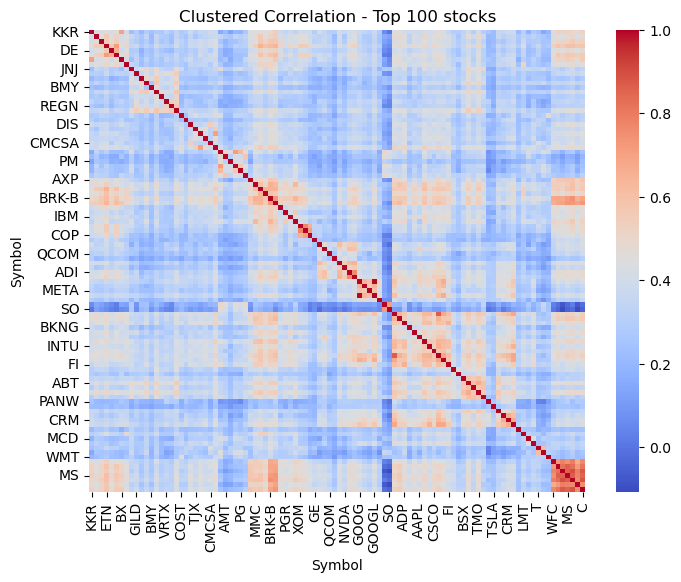

In [225]:
sns.heatmap(correlation_matrix_top_100_5y_c,cmap='coolwarm')
plt.title('Clustered Correlation - Top 100 stocks')
plt.savefig('figures/Heatmap_top100_clustered.png')
plt.show()

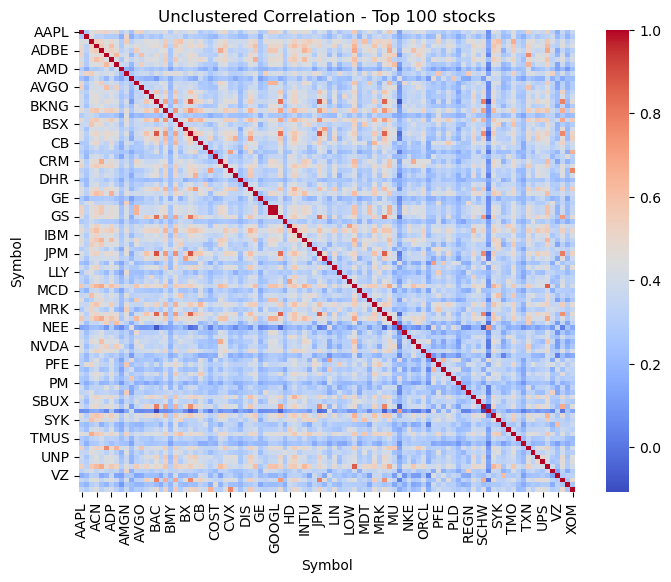

In [168]:
sns.heatmap(correlation_matrix_top_100_5y,cmap='coolwarm')
plt.title('Unclustered Correlation - Top 100 stocks')
plt.show()

Once again, we see emerging structure from the blocks in the clustered correlation matrix!

## Appendix - The effect of denoising on clustering?

Let us briefly analyze clustering without denoising the correlation matrix. Even though the conclusion will be somewhat qualitative, we will argue that clustering was more succesful in the previous case, where we denoised the matrix first.

Let us do construct again the matrix $X=\sqrt{\frac{1-\rho}{2}}$, but using the original correlation matrix.

In [169]:
X_den_top_100_alt=np.sqrt((1-correlation_matrix_top_100_5y)/2)

As before, we use 9 PCA components, as our fit for the random range suggested.

In [170]:
pca_scaled = PCA(n_components= 9)

X_den_top_100_PCA_array_alt = pca_scaled.fit_transform(X_den_top_100_alt)

In [171]:
X_den_top_100_PCA_alt = pd.DataFrame(X_den_top_100_PCA_array_alt, columns = ['PC0', 'PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8'], index = list_stocks_top100)

In [172]:
# let us do head in order to check the correlation after PCA transformed
X_den_top_100_PCA_alt.head()

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8
AAPL,-0.144341,-0.240739,0.115541,0.115035,-0.052181,-0.042136,0.032609,-0.111615,0.029968
ABBV,0.308890,-0.011164,0.097900,-0.337766,-0.044898,-0.072384,0.008690,-0.023273,0.051859
ABT,-0.247109,-0.179134,-0.243941,-0.280339,-0.122515,0.080430,-0.000769,0.043490,0.043711
ACN,-0.356206,-0.157415,-0.296457,0.078936,-0.041945,0.019679,-0.023393,0.037174,-0.037184
ADBE,-0.239224,-0.489361,-0.055874,0.060689,0.032341,0.030824,-0.026224,0.105363,-0.090012


Test the 3 clustering for silhouette score

In [173]:
# Test number of cluster
ks3 = np.arange(2, 50)
silScoresKMeans3 = []
silScoresGauss3 = []
silScoresAgglom3 = []

In [175]:
for k in ks3:
    print(f'Currently working on k = {k}')

    #instantiate these three models
    kmeans3 = KMeans(n_clusters = k)
    gauss3 = GaussianMixture(n_components = k)
    agglom3 = AgglomerativeClustering(n_clusters = k, linkage = 'ward')

    #fit the three models to the data
    kmeans3.fit(X_den_top_100_PCA_alt)
    gauss3.fit(X_den_top_100_PCA_alt)
    agglom3.fit(X_den_top_100_PCA_alt)

    #populate the lists with the silhouette scores!
    silScoresKMeans3.append(silhouette_score(X_den_top_100_PCA_alt, kmeans3.labels_))
    silScoresAgglom3.append(silhouette_score(X_den_top_100_PCA_alt, agglom3.labels_))
    silScoresGauss3.append(silhouette_score(X_den_top_100_PCA_alt, gauss3.predict(X_den_top_100_PCA_alt)))

Currently working on k = 2
Currently working on k = 3
Currently working on k = 4
Currently working on k = 5
Currently working on k = 6
Currently working on k = 7
Currently working on k = 8
Currently working on k = 9
Currently working on k = 10
Currently working on k = 11
Currently working on k = 12
Currently working on k = 13
Currently working on k = 14
Currently working on k = 15
Currently working on k = 16
Currently working on k = 17
Currently working on k = 18
Currently working on k = 19
Currently working on k = 20
Currently working on k = 21
Currently working on k = 22
Currently working on k = 23
Currently working on k = 24
Currently working on k = 25
Currently working on k = 26
Currently working on k = 27
Currently working on k = 28
Currently working on k = 29
Currently working on k = 30
Currently working on k = 31
Currently working on k = 32
Currently working on k = 33
Currently working on k = 34
Currently working on k = 35
Currently working on k = 36
Currently working on k = 37


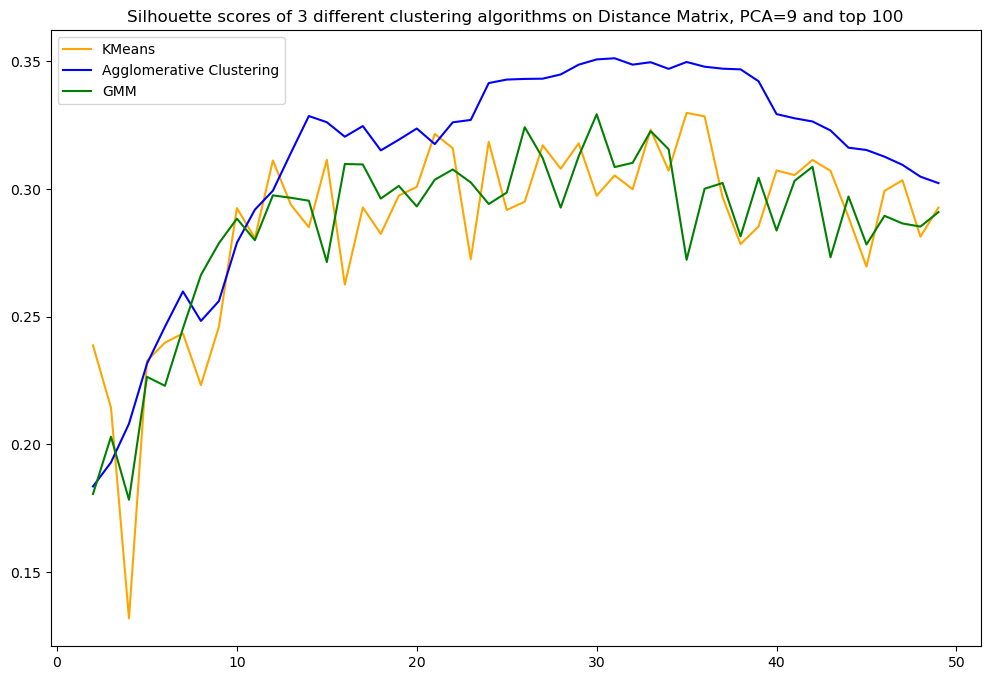

In [177]:
plt.figure(figsize=(12,8))
plt.plot(ks3, silScoresKMeans3, label='KMeans', color='orange')
plt.plot(ks3, silScoresAgglom3, label='Agglomerative Clustering', color='blue')
plt.plot(ks3, silScoresGauss3, label='GMM', color='green')
plt.legend() 
plt.title('Silhouette scores of 3 different clustering algorithms on Distance Matrix, PCA=9 and top 100')
plt.show()

We see overall that Agglomerative Clustering did better again. Also, $k=16$ still leads to a decent Silhhouette score, and it should make comparison to the denoised case more straightforward.

In [178]:
agglom_top100_alt = AgglomerativeClustering(n_clusters = 16, linkage = 'ward')
agglom_top100_alt.fit(X_den_top_100_PCA_alt)
agglom_top100_Labels_alt = agglom_top100_alt.fit_predict(X_den_top_100_PCA_alt)

Now let us create a temporary DataFrame including the labels the algorithm produced

In [179]:
data_explore_top100_alt={'Stocks':list_stocks_top100,'Category':agglom_top100_Labels_alt}

In [180]:
data_explore_top100_alt_df=pd.DataFrame(data_explore_top100_alt)

Let us compare the number of stocks per cluster, starting with the __not denoised__.

In [197]:
print('')
print('Count per clustered category - Not denoised')
print('')
data_explore_top100_alt_df.groupby('Category').count()


Count per clustered category - Not denoised



,Stocks
Category,
0,10
1,10
2,15
3,9
4,5
5,7
6,7
7,7
8,6


Let us print again the __denoised__ clustering we perfomed in the previous section.

In [198]:
print('')
print('Count per clustered category - denoised')
print('')
data_explore_top100_df.groupby('Category').count()


Count per clustered category - denoised



,Stocks
Category,
0,8
1,10
2,8
3,6
4,10
5,4
6,8
7,5
8,2


It seems that clustering __without denoising__ first created __less evenly distributed clusters__! It is not a huge difference, but let us compare the cluster with the most classes in them in both.

#### Not denoised - Cluster with most stocks

In [206]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_alt_df[data_explore_top100_alt_df['Category']==2]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,236.48,3595465654272,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.065970
16,NYQ,ORCL,Oracle Corporation,Oracle Corporation,Technology,Software - Infrastructure,173.76,481499348992,2.180300e+10,0.069,Austin,TX,United States,159000.0,Oracle Corporation offers products and service...,0.008835
33,NMS,LIN,Linde plc,Linde plc,Basic Materials,Specialty Chemicals,483.36,230805848064,1.239800e+10,0.008,Woking,NaN,United Kingdom,65987.0,Linde plc operates as an industrial gas compan...,0.004235
36,NMS,CSCO,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,Communication Equipment,56.59,225835417600,1.528200e+10,-0.103,San Jose,CA,United States,90400.0,"Cisco Systems, Inc. designs, manufactures, and...",0.004144
39,NYQ,IBM,International Business Machines,International Business Machines Corporation,Technology,Information Technology Services,231.75,213476048896,1.462500e+10,0.019,Armonk,NY,United States,282200.0,"International Business Machines Corporation, t...",0.003917
41,NYQ,BX,Blackstone Inc.,Blackstone Inc.,Financial Services,Asset Management,170.77,210059067392,NaN,0.541,New York,NY,United States,4735.0,Blackstone Inc. is an alternative asset manage...,0.003854
44,NYQ,AXP,American Express Company,American Express Company,Financial Services,Credit Services,270.74,190721425408,NaN,0.080,New York,NY,United States,74600.0,"American Express Company, together with its su...",0.003499
46,NYQ,CAT,"Caterpillar, Inc.",Caterpillar Inc.,Industrials,Farm & Heavy Construction Machinery,390.48,189342973952,1.618200e+10,-0.036,Irving,TX,United States,113200.0,Caterpillar Inc. manufactures and sells constr...,0.003474
58,NYQ,RTX,RTX Corporation,RTX Corporation,Industrials,Aerospace & Defense,125.90,167477215232,9.217000e+09,0.077,Arlington,VA,United States,185000.0,"RTX Corporation, an aerospace and defense comp...",0.003073
69,NYQ,UNP,Union Pacific Corporation,Union Pacific Corporation,Industrials,Railroads,240.35,146420744192,1.176900e+10,0.007,Omaha,NE,United States,30804.0,"Union Pacific Corporation, through its subsidi...",0.002687


This cluster contains many different industries together!

By comparison, the cluster class with the most stocks using the __denoised__ matrix, it contains mostly big tech and financial industries, whcih due to online shopping does seem to generally have relevant correlation.

In [208]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_df[data_explore_top100_df['Category']==9]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
0,NMS,AAPL,Apple Inc.,Apple Inc.,Technology,Consumer Electronics,236.48,3595465654272,1.317810e+11,0.049,Cupertino,CA,United States,161000.0,"Apple Inc. designs, manufactures, and markets ...",0.065970
2,NMS,MSFT,Microsoft Corporation,Microsoft Corporation,Technology,Software - Infrastructure,418.78,3112808480768,1.294330e+11,0.152,Redmond,WA,United States,228000.0,Microsoft Corporation develops and supports so...,0.057115
13,NYQ,V,Visa Inc.,Visa Inc.,Financial Services,Credit Services,286.85,558175682560,2.438400e+10,0.096,San Francisco,CA,United States,NaN,Visa Inc. operates as a payment technology com...,0.010242
16,NYQ,ORCL,Oracle Corporation,Oracle Corporation,Technology,Software - Infrastructure,173.76,481499348992,2.180300e+10,0.069,Austin,TX,United States,159000.0,Oracle Corporation offers products and service...,0.008835
17,NYQ,MA,Mastercard Incorporated,Mastercard Incorporated,Financial Services,Credit Services,515.01,475784282112,1.624400e+10,0.110,Purchase,NY,United States,33400.0,"Mastercard Incorporated, a technology company,...",0.008730
32,NYQ,ACN,Accenture plc,Accenture plc,Technology,Information Technology Services,376.03,234964598784,1.106591e+10,0.026,Dublin,NaN,Ireland,774000.0,Accenture plc provides strategy and consulting...,0.004311
36,NMS,CSCO,"Cisco Systems, Inc.","Cisco Systems, Inc.",Technology,Communication Equipment,56.59,225835417600,1.528200e+10,-0.103,San Jose,CA,United States,90400.0,"Cisco Systems, Inc. designs, manufactures, and...",0.004144
55,NMS,INTU,Intuit Inc.,Intuit Inc.,Technology,Software - Application,613.93,172079661056,4.496000e+09,0.410,Mountain View,CA,United States,18800.0,"Intuit Inc. provides financial management, com...",0.003157
60,NYQ,SPGI,S&P Global Inc.,S&P Global Inc.,Financial Services,Financial Data & Stock Exchanges,523.19,163758473216,6.361000e+09,0.144,New York,NY,United States,40450.0,"S&P Global Inc., together with its subsidiarie...",0.003005
70,NMS,BKNG,Booking Holdings Inc. Common St,Booking Holdings Inc.,Consumer Cyclical,Travel Services,4363.72,146291097600,6.987000e+09,0.073,Norwalk,CT,United States,24150.0,"Booking Holdings Inc., together with its subsi...",0.002684


Also it created some cluster classes with very few stocks in them: For instance, one of them had only google!

In [209]:
df_companies[df_companies['Symbol'].isin(data_explore_top100_alt_df[data_explore_top100_alt_df['Category']==13]['Stocks'])]

,Exchange,Symbol,Shortname,Longname,Sector,Industry,Currentprice,Marketcap,Ebitda,Revenuegrowth,City,State,Country,Fulltimeemployees,Longbusinesssummary,Weight
3,NMS,GOOG,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,165.80,2029989003264,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037247
4,NMS,GOOGL,Alphabet Inc.,Alphabet Inc.,Communication Services,Internet Content & Information,164.07,2028840550400,1.154780e+11,0.136,Mountain View,CA,United States,179582.0,Alphabet Inc. offers various products and plat...,0.037226


It would be worth to investigate more the influence of denoising on clustering, as well as other metric distances constructed from correlation, but it does seem that for the problem we analyzed, denoising the eigenvalues was a useful technique.